In [206]:
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [6]:
train_set = pd.read_csv('data/train.csv')
test_set = pd.read_csv('data/test.csv')
Y = train_set.pop('FloodProbability').to_numpy()
train_set.drop('id',axis='columns', inplace=True)


In [9]:
X_labels = train_set.columns
X = train_set.to_numpy()
print(X.shape)

(1117957, 20)


In [127]:
x_train, x_cv, y_train, y_cv = train_test_split(X,Y,test_size=0.3)
x_train = torch.Tensor(x_train)
y_train = torch.Tensor(y_train).unsqueeze(1)
y_cv = torch.Tensor(y_cv).unsqueeze(1)
print(x_train)

tensor([[7., 4., 4.,  ..., 6., 4., 7.],
        [9., 6., 5.,  ..., 4., 6., 3.],
        [6., 3., 5.,  ..., 5., 2., 4.],
        ...,
        [2., 2., 5.,  ..., 8., 5., 6.],
        [6., 5., 6.,  ..., 2., 5., 2.],
        [4., 4., 4.,  ..., 5., 2., 5.]])


In [128]:
scaler = StandardScaler().fit(x_train)
x_train = torch.Tensor(scaler.transform(x_train))
x_cv = torch.Tensor(scaler.transform(x_cv))
print(x_train)

tensor([[ 1.0109, -0.4429, -0.4603,  ...,  0.5084, -0.4530,  0.9873],
        [ 1.9843,  0.5124,  0.0220,  ..., -0.4589,  0.5081, -0.9284],
        [ 0.5243, -0.9206,  0.0220,  ...,  0.0248, -1.4142, -0.4495],
        ...,
        [-1.4224, -1.3982,  0.0220,  ...,  1.4757,  0.0275,  0.5084],
        [ 0.5243,  0.0347,  0.5042,  ..., -1.4262,  0.0275, -1.4073],
        [-0.4491, -0.4429, -0.4603,  ...,  0.0248, -1.4142,  0.0294]])


In [194]:
class floodProb(nn.Module):
    def __init__(self):
        '''Populate with the layers of the model'''
        super(floodProb,self).__init__()

        # define layers
        self.input = nn.Linear(in_features=20,out_features=10)
        self.hidden1 = nn.Linear(10,5)
        self.output = nn.Linear(5,1)

    def forward(self,x):
        '''Operations that are taking place in the layers'''

        # input
        x = F.relu(self.input(x))
        x = F.relu(self.hidden1(x))
        # output
        x = self.output(x)

        return x

In [195]:

def create_model(lr,lossfun):
    model = floodProb()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    lossfun = torch.nn.MSELoss()  
    return model, lossfun, optimizer

In [208]:
def train(model, lossfun, optimizer, inputs, targets, epochs=100):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    inputs, targets = inputs.to(device), targets.to(device)
    
    losses = np.zeros(epochs)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = lossfun(outputs, targets)
        loss.backward()
        optimizer.step()
        losses[epoch] = loss.item()
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch}/{epochs} - Loss: {loss.item()}')
    return losses

In [210]:

 # Set seed for reproducibility
epochs = 200
num_lr = 100
lrs = np.linspace(0.01, 0.1, 100)
all_losses = np.zeros((epochs, num_lr))
all_cv = np.zeros((1, num_lr))

torch.manual_seed(0)

for idx, lr in enumerate(lrs):
    model = floodProb()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr) 
    if idx == 0:
        initial_state = copy.deepcopy(model.state_dict())
    else:
        model.load_state_dict(copy.deepcopy(initial_state))
    model.train()
    losses = train(model, nn.MSELoss(), optimizer, x_train, y_train,epochs=epochs)
    
    model.eval()
    with torch.no_grad():
        outputs = model(x_cv)
        loss_cv = nn.MSELoss()(outputs, y_cv)
        
    all_cv[0, idx] = loss_cv.item()
    all_losses[:, idx] = losses

Epoch 0/200 - Loss: 0.40569111704826355
Epoch 10/200 - Loss: 0.0389363132417202
Epoch 20/200 - Loss: 0.01462631393224001
Epoch 30/200 - Loss: 0.014603469520807266
Epoch 40/200 - Loss: 0.007940693758428097
Epoch 50/200 - Loss: 0.0047516291961073875
Epoch 60/200 - Loss: 0.003565907711163163
Epoch 70/200 - Loss: 0.0026873841416090727
Epoch 80/200 - Loss: 0.0020806528627872467
Epoch 90/200 - Loss: 0.001634688233025372
Epoch 100/200 - Loss: 0.0013167248107492924
Epoch 110/200 - Loss: 0.0010917449835687876
Epoch 120/200 - Loss: 0.0009322366095148027
Epoch 130/200 - Loss: 0.0008190657244995236
Epoch 140/200 - Loss: 0.0007376248831860721
Epoch 150/200 - Loss: 0.0006776926456950605
Epoch 160/200 - Loss: 0.0006321141845546663
Epoch 170/200 - Loss: 0.0005962296854704618
Epoch 180/200 - Loss: 0.0005669852835126221
Epoch 190/200 - Loss: 0.0005425244453363121
Epoch 0/200 - Loss: 0.40569111704826355
Epoch 10/200 - Loss: 0.0444113127887249
Epoch 20/200 - Loss: 0.011985384859144688
Epoch 30/200 - Loss:

(Text(0.5, 0, 'Learning rate'), Text(0, 0.5, 'Loss on Dev'))

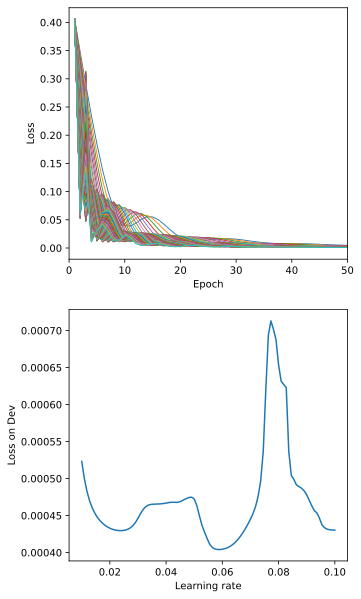

In [215]:
# show the losses
fig,ax = plt.subplots(2,figsize=(5,10), gridspec_kw={'height_ratios': [1, 1]})
for idx,lr in enumerate(lrs):
    ax[0].plot(range(1,201),all_losses[:,idx],'-',markerfacecolor='w',linewidth=.9,label=f"{np.round(lr,3)}")
    ax[0].set_xlim((0,50))
    ax[0].set_xlabel('Epoch'), ax[0].set_ylabel('Loss')
ax[1].plot(lrs,all_cv.flatten())
ax[1].set_xlabel('Learning rate'), ax[1].set_ylabel('Loss on Dev')


(200, 100)


(Text(0.5, 0, 'Learning rate'), Text(0, 0.5, 'Loss on Dev'))

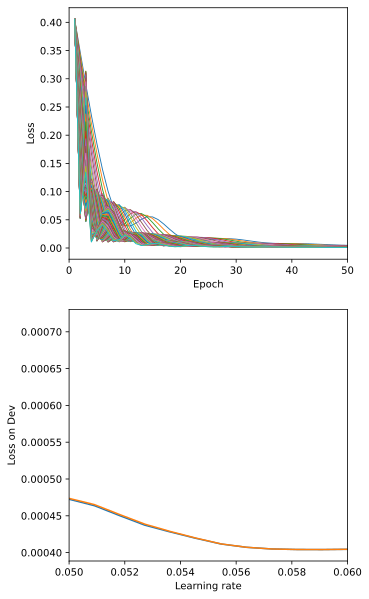

In [229]:
# show the losses
fig,ax = plt.subplots(2,figsize=(5,10), gridspec_kw={'height_ratios': [1, 1]})
for idx,lr in enumerate(lrs):
    ax[0].plot(range(1,201),all_losses[:,idx],'-',markerfacecolor='w',linewidth=.9,label=f"{np.round(lr,3)}")
    ax[0].set_xlim((0,50))
    ax[0].set_xlabel('Epoch'), ax[0].set_ylabel('Loss')
ax[1].plot(lrs,all_cv.flatten())
print(all_losses.shape)
ax[1].plot(lrs[:],all_losses[-1,:])
ax[1].set_xlim((0.05,0.06))
ax[1].set_xlabel('Learning rate'), ax[1].set_ylabel('Loss on Dev')


In [ ]:

lr = 0.02
lossfuns = nn.MSELoss()